In [ ]:
# First we need to install the MNE package for visualizing the EEG data
#One time MNE install for current user: 
#Open a terminal:
#pip install --user --upgrade --no-deps git+https://github.com/mne-tools/mne-python.git
# *back in jupyter notebook* 
# In upper toolbar, click Kernel -> Restart and Clear Output
# Now the next cell should run fine

In [1]:
from SciServer import CasJobs, Files, Authentication
import sys
import os.path
import statistics
from matplotlib import pyplot as plt
import pandas
import numpy as np
import mne
from sklearn.utils import shuffle, class_weight #pip install --user sklearn


pwd = !pwd
project_path = pwd[0]
if project_path not in sys.path:
    sys.path.append(project_path)

In [2]:
class MNEDataWrapper:
    
    def loadSession(self, session_ID):
        print("Querying session {0} from CasJobs".format(session_ID))
        
        info = mne.create_info(self.channel_names, self.recorded_sample_freq, self.channel_types, self.montage)
        info['description'] = '16 channel EEG sessionID {0}'.format(session_ID)
        
        raw_query = "select * from public.ncarey.session_eeg where session_ID = {0} order by timestamp".format(session_ID)
        raw_df = CasJobs.executeQuery(sql=raw_query, context=self.casjobs_context)

        raw_data = []
        for index in range(len(self.channel_names)):
            raw_data.append(raw_df[self.channel_names[index]].values)

        custom_raw = mne.io.RawArray(raw_data, info)
        
        # we do this query to get the data reading index at which the stims appear.  IE, instead of 
        # saying stim X was presented at time Y (as it is in the raw data), we want to 
        # say stim X appeared at data reading index Z
        stim_index_query = '''
            with stim_timestamps_index(index_value, timestamp) as (
            select count(*), stim_timestamps.timestamp from public.ncarey.session_eeg, public.ncarey.stim_timestamps 
            where session_eeg.session_ID = {0} and stim_timestamps.session_ID = {0} and session_eeg.timestamp < stim_timestamps.timestamp 
            group by stim_timestamps.timestamp
            )

            select stim_timestamps_index.index_value, stim_timestamps.stim_ID from stim_timestamps_index, public.ncarey.stim_timestamps 
            where stim_timestamps.session_ID = {0} and stim_timestamps.timestamp = stim_timestamps_index.timestamp
            order by stim_timestamps_index.index_value'''.format(session_ID)

        stim_index_df = CasJobs.executeQuery(sql=stim_index_query, context=self.casjobs_context)

        stim_ind = stim_index_df['index_value'].values
        stim_ID = stim_index_df['stim_ID'].values

        events = []
        for i in range(len(stim_ind)):
            events.append([stim_ind[i]+1, 0, stim_ID[i]])
        
        epochs = mne.Epochs(raw=custom_raw, events=events, event_id=self.event_id_dict, tmin=self.epoch_tmin, tmax=self.epoch_tmax)

        # Now we load the epochs into their respective target and distractor arrays of epochs
        # More importantly, we downsample to 128Hz, which is the input sampling rate EEGNet is setup for
        
        #Downsample to 128Hz
        
        epochs.load_data()
        epochs_resampled = epochs.copy().resample(self.resample_rate, npad='auto')

        target_epochs = epochs_resampled[self.target_epoch_names]
        distract_epochs = epochs_resampled[self.distract_epoch_names]
        
        
        self.sessions[session_ID] = [target_epochs, distract_epochs]
        
        #return target_epochs, distract_epochs 
    
    #converts from MNE Object to an array-format that can be consumed by EEGNet
    def MNEtoEEGNetArray(self, session_ID):
        target_epochs = self.sessions[session_ID][0]
        distract_epochs = self.sessions[session_ID][1]
        
        target_data = target_epochs.get_data()  # len(target_epochs) epochs of 16 channels x 128 readings
        distract_data = distract_epochs.get_data()

        target_class = np.array([1,0], ndmin=2)
        distract_class = np.array([0,1], ndmin=2)
        
        input_data = np.array(target_data[0], ndmin=4)
        input_class = target_class

        for i in range(1, len(target_data)):
            cur_epoch = np.array(target_data[i], ndmin=4)
            input_data = np.append(input_data, cur_epoch, axis=0)
            input_class = np.append(input_class, target_class, axis=0)
    
        for i in range(0, len(distract_data)):
            cur_epoch = np.array(distract_data[i], ndmin=4)
            input_data = np.append(input_data, cur_epoch, axis=0)
            input_class = np.append(input_class, distract_class, axis=0)
            
        return input_data, input_class
        
    
    #trainingSessions and evaluationSessions are arrays of SessionIDs to include in the respective numpy array files
    def saveToFile(self, trainingSessionsToSave, evaluationSessionsToSave):
        training_data = []
        training_class = []
        eval_data = []
        eval_class = []
        
        for session_ID in trainingSessionsToSave:
            input_data, input_class = self.MNEtoEEGNetArray(session_ID)
            if len(training_data) == 0:
                training_data = input_data
                training_class = input_class
            else:
                training_data = np.append(training_data, input_data, axis=0)
                training_class = np.append(training_class, input_class, axis=0)
            
        for session_ID in evaluationSessionsToSave:
            input_data, input_class = self.MNEtoEEGNetArray(session_ID)
            if len(eval_data) == 0:
                eval_data = input_data
                eval_class = input_class
            else:
                eval_data = np.append(eval_data, input_data, axis=0)
                eval_class = np.append(eval_class, input_class, axis=0)        
        
        np.save("training_data", training_data)
        np.save("training_class", training_class)
        np.save("eval_data", eval_data)
        np.save("eval_class", eval_class)

        
    def __init__(self):
        
        # MNE-specific information
        self.channel_names = ['F3', 'Fz', 'F4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'Cp3', 'Cp4', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']
        self.channel_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
        self.recorded_sample_freq = 512
        self.montage = 'standard_1005'
        self.target_epoch_names = ['t_01', 't_02', 't_03', 't_04']
        self.distract_epoch_names = ['d_01', 'd_02', 'd_03', 'd_04', 'd_05', 'd_06', 'd_07', 'd_08', 'd_09', 'd_10']
        self.event_id_dict = dict(t_04=0, t_03=1, t_02=2, t_01=3, d_10=4, d_09=5, d_08=6, d_07=7, d_06=8, d_05=9, d_04=10, d_03=11, d_02=12, d_01=13)
        self.epoch_tmin = 0
        self.epoch_tmax = 1
        self.resample_rate = 128 #desired sample freq in Hz for EEGNet input 
        
        self.casjobs_context = "MyDB"
        
        self.sessions = {}
 

In [3]:
MNEDataWrap = MNEDataWrapper()
for i in range(2,20):
    MNEDataWrap.loadSession(i)


Querying session 2 from CasJobs
Creating RawArray with float64 data, n_channels=16, n_times=81968
    Range : 0 ... 81967 =      0.000 ...   160.092 secs
Ready.
320 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 320 events and 513 original time points ...
0 bad epochs dropped
Querying session 3 from CasJobs
Creating RawArray with float64 data, n_channels=16, n_times=93728
    Range : 0 ... 93727 =      0.000 ...   183.061 secs
Ready.
400 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 400 events and 513 original time points ...
0 bad epochs dropped
Querying session 4 from CasJobs
Creating RawArray with float64 data, n_channels=16, n_times=93856
    Range : 0 ... 93855 =      0.000 ...   183.311 secs
Ready.
400 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated

In [4]:
MNEDataWrap.saveToFile([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],[19])

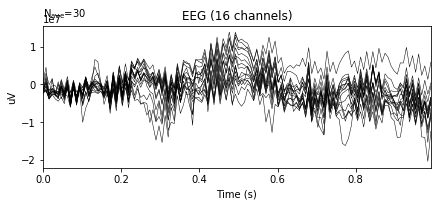

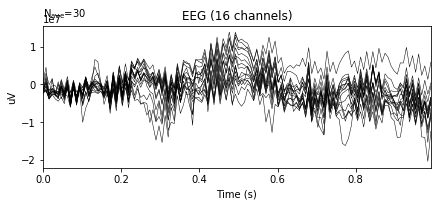

In [13]:
#Plotting the average of all session [15]'s target ([0]) responses 
MNEDataWrap.sessions[15][0].average().plot(time_unit='s')

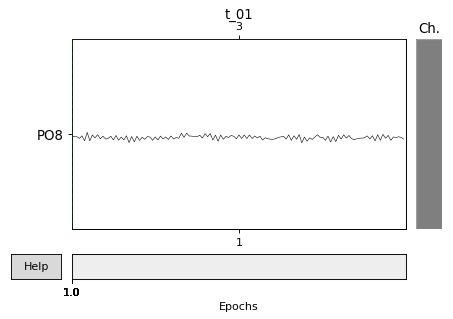

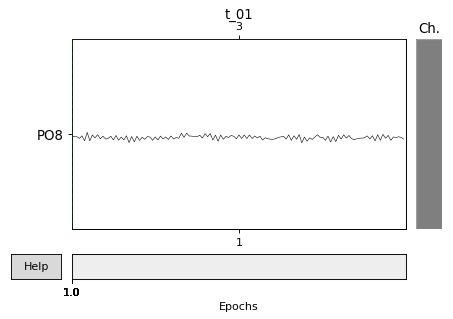

In [12]:
#plotting a single target response from session 15
MNEDataWrap.sessions[15][0][1].plot(scalings='auto')
#MNEDataWrap.sessions[15][0][1].plot(picks=[14], scalings='auto')